In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import sys
import random, pickle
from os.path import join as oj
from tqdm import tqdm
sys.path.insert(1, oj(sys.path[0], 'mnist'))
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy
cs_div = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
sns.set_style(style='white')
sns.set_palette("husl")

import torch
import foolbox
import mnist.mnist as dset
from mnist.mnist import pred_ims
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from conv2dnp import conv2dnp
import visualize as viz
import tiling
import agglomerate
from cd import cd
import scores

# load the model
model = dset.Net().cuda()
model.load_state_dict(torch.load('mnist/mnist.model'))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## generate adversarial examples

In [55]:
def get_scores(im_num, model, dset, attack_type='saliency', sweep_dim=2, use_abs_score=False):
    # seed
    np.random.seed(13)
    random.seed(13)
    torch.manual_seed(13)
    
    # pick im
    im_torch, im_orig, label = dset.get_im_and_label(im_num)
    targeted = False
#     if targeted:
    #     target = choose_target(model, im_torch, label) # only for targeted attacks
#         target = 7

    # generate adv_perturb
    pix_min = np.min(im_torch.data.cpu().numpy())
    pix_max = np.max(im_torch.data.cpu().numpy())
    fmodel = foolbox.models.PyTorchModel(model, bounds=(pix_min-1, pix_max+1), 
                                         num_classes=10, channel_axis=1)
    if attack_type == 'saliency':
        attack = foolbox.attacks.SaliencyMapAttack(fmodel) # saliency map attack has some good stuff
    elif attack_type == 'fgsm':
        attack = foolbox.attacks.FGSM(fmodel) # saliency map attack has some good stuff
    elif attack_type == 'gradientattack':
        attack = foolbox.attacks.GradientAttack(fmodel) # saliency map attack has some good stuff
    elif attack_type == 'deepfoolattack':
        attack = foolbox.attacks.DeepFoolAttack(fmodel) # saliency map attack has some good stuff
    elif attack_type == 'boundaryattack':
        attack = foolbox.attacks.BoundaryAttack(fmodel) # saliency map attack has some good stuff

    if attack_type == 'boundaryattack':
        im_orig_adv = attack(im_torch.data.cpu().numpy()[0], label, log_every_n_steps=10000)
    elif attack_type == 'random':
        #print(im_torch.data.cpu().numpy()[0].shape)
        im_orig_adv = (im_torch.data.cpu().numpy()[0] + 0.4 * (2 * np.random.randint(2, size=(1, 28, 28)) - 1)).astype(np.float32)
    else:
        im_orig_adv = attack(im_torch.data.cpu().numpy()[0], label)

    # set up vars
    im_torch_adv = Variable(torch.from_numpy(np.expand_dims(im_orig_adv, 0)).cuda(), requires_grad=True)
    im_orig_adv = im_orig_adv[0] # make this 28 x 28
    results = {}

    # see predictions
    pred_orig = model(im_torch).exp().data.cpu().numpy().flatten()
    pred_adv = model(im_torch_adv).exp().data.cpu().numpy().flatten()
    print(pred_orig)
    print(pred_adv)
    if not targeted:
        target = np.argmax(pred_adv)
#     print('\tlabel:', label, pred_orig[label], '->', pred_adv[label])
#     print('\ttarget:', target, pred_orig[target], '->', pred_adv[target])
    results['label'] = label
    results['pred_orig[label]'] = pred_orig[label]
    results['pred_adv[label]'] = pred_adv[label]
    results['target'] = target
    results['pred_orig[target]'] = pred_orig[target]
    results['pred_adv[target]'] = pred_adv[target]
    results['sweep_dim'] = sweep_dim
    results['use_abs_score'] = use_abs_score
    results['attack_type'] = attack_type
    
    scores_ig = scores.ig_scores_cnn(model, Variable(im_torch.data, requires_grad=True))
    scores_ig_adv = scores.ig_scores_cnn(model, im_torch_adv)
    #scores_ig_label = scores.ig_scores_cnn(Variable(im_torch.data, requires_grad=True), label, model)
    #scores_ig_adv_label = scores.ig_scores_cnn(model, im_torch_adv, label)

    return scores_ig, scores_ig_adv, label, target


    # get scores
    tiles_cd = tiling.gen_tiles(im_orig, fill=0, method='cd', sweep_dim=sweep_dim)
    scores_cd = agglomerate.get_scores(model, method='cd', ims=tiles_cd, im_torch=im_torch)[:, target]
    scores_cd_adv = agglomerate.get_scores(model, method='cd', ims=tiles_cd, im_torch=im_torch_adv)[:, target]

    tiles_build = tiling.gen_tiles(im_orig, fill=0, method='build_up', sweep_dim=sweep_dim)
    scores_build = agglomerate.get_scores(model, method='build_up', ims=tiles_build, 
                                   im_torch=im_torch, pred_ims=pred_ims, layer='softmax')[:, target]
    tiles_build_adv = tiling.gen_tiles(im_orig_adv, fill=0, method='build_up', sweep_dim=sweep_dim)
    scores_build_adv = agglomerate.get_scores(model, method='build_up', ims=tiles_build_adv, 
                                   im_torch=im_torch, pred_ims=pred_ims, layer='softmax')[:, target]
 
    tiles_break = tiling.gen_tiles(im_orig, fill=0, method='break_down', sweep_dim=sweep_dim)
    scores_break = agglomerate.get_scores(model, method='break_down', ims=tiles_break, 
                                    im_torch=im_torch, pred_ims=pred_ims)[:, target]
    tiles_break_adv = tiling.gen_tiles(im_orig_adv, fill=0, method='break_down', sweep_dim=sweep_dim)
    scores_break_adv = agglomerate.get_scores(model, method='break_down', ims=tiles_break_adv, 
                                    im_torch=im_torch, pred_ims=pred_ims)[:, target]
    

    ## derived scores
    scores_diff = scores_cd_adv - scores_cd
    scores_diff_build = scores_build_adv - scores_build
    scores_diff_break = scores_break_adv - scores_break
    scores_diff_ig = scores_ig_adv_target - scores_ig_target
    diff_abs = np.abs(im_orig_adv - im_orig)
    
    # handle sweep_dim
    if sweep_dim > 1:
        kernel = np.ones(shape=(sweep_dim, sweep_dim, 1, 1))
 
        # convolve pixel diffs (add them over a window)

        diff_abs = np.expand_dims(diff_abs, 0)
        diff_abs = np.expand_dims(diff_abs, -1)
        print('shape', diff_abs.shape)
        diff_abs = conv2dnp(diff_abs, kernel, stride=(sweep_dim, sweep_dim))
        
        # convolve ig scores (add them over a window)
        scores_diff_ig = np.expand_dims(scores_diff_ig, 0)
        scores_diff_ig = np.expand_dims(scores_diff_ig, -1)
        scores_diff_ig = conv2dnp(scores_diff_ig, kernel, stride=(sweep_dim, sweep_dim))
    scores_diff_ig = scores_diff_ig.flatten()
    
     ## select top pixels
    diff_abs_flat = diff_abs.flatten()
    thresh = np.percentile(diff_abs_flat, 95) # percentile from 0-100, higher picks less    
    selected_pixels = diff_abs_flat > thresh
    unchanged = diff_abs_flat <= thresh
    
    # make list and iterate
    score_names = ['cd', 'build', 'break', 'ig']
    scores_list = [scores_diff, scores_diff_build, scores_diff_break, scores_diff_ig]
    if use_abs_score:
        scores_list = [np.abs(s) for s in scores_list]
    for i, score_name in enumerate(score_names):       
        # calculate stats
    #     cd_mean_score_diff_selected = np.mean(scores_list[i][selected_pixels][:, target])
    #     cd_mean_score_diff_unchanged = np.mean(scores_list[i][unchanged][:, target])
        rank_data = scipy.stats.rankdata(scores_list[i], method='min') / 784
        mean_rank_selected = np.mean(rank_data[selected_pixels])
        mean_rank_unchanged = np.mean(rank_data[unchanged])
        results[score_name + '_mean_score_diff_selected'] = mean_rank_selected
        results[score_name + '_mean_score_diff_unchanged'] = mean_rank_unchanged
     
    return results, [im_orig, im_orig_adv, diff_abs_flat, scores_diff, scores_diff_build, scores_diff_break, scores_diff_ig, selected_pixels, unchanged]

results_list = []
start, end = 250, 251 # 350
ats = ['fgsm'] # ['fgsm', 'saliency', 'gradientattack', 'deepfoolattack', 'boundaryattack']
sweep_dims = [2] # [1, 2, 4, 8]
use_abs_scores = [False, True]
for use_abs_score in use_abs_scores:
    for sweep_dim in sweep_dims:
        for attack_type in ats:
            for im_num in tqdm(range(start, end)):
                if im_num == end - 1: # extra run to set vars
                    results, [im_orig, im_orig_adv, diff_abs_flat, scores_diff, scores_diff_build, scores_diff_break, scores_diff_ig, selected_pixels, unchanged] = get_scores(im_num, model, dset, attack_type)
                else:
                    results_list.append(get_scores(im_num, model, dset, attack_type, use_abs_score=use_abs_score)[0])
            pickle.dump(results_list, open('adv_results/results_list_' + attack_type + 
                                           '_' + str(start) + '-' + str(end) + 
                                           'sweep_dim=' + str(sweep_dim) + 
                                           'use_abs=' + str(use_abs_score) + '.pkl', 'wb'))

  0%|          | 0/1 [00:00<?, ?it/s]

[1.6887435e-04 2.1858718e-02 1.8515798e-01 6.7613387e-01 3.7205350e-04
 4.7233384e-04 2.8019209e-05 6.6621237e-02 4.0472373e-02 8.7147001e-03]
[7.67181802e-04 3.13545652e-02 3.74295056e-01 3.66803169e-01
 1.18048897e-03 1.28211209e-03 2.04802884e-04 9.90948603e-02
 1.10218994e-01 1.47990333e-02]


/accounts/grad/jmurdoch/pytorch/agglomerative_attention/scores.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(model(input_vecs))[:, class_to_explain]



ValueError: too many values to unpack (expected 2)

In [74]:
im_num = 3371
scores_ig, scores_ig_adv, label, target = get_scores(im_num, model, dset, attack_type='saliency', sweep_dim=1, use_abs_score=False)



[5.3531156e-08 7.9569089e-09 1.0545319e-07 6.8531909e-07 1.5174765e-03
 9.2444566e-07 5.0257349e-09 5.7185517e-04 7.6672135e-05 9.9783176e-01]
[6.5876861e-08 5.4707016e-07 8.2213427e-07 4.0159401e-07 5.6361747e-01
 1.5999973e-06 4.3664599e-07 4.3944118e-04 6.7149755e-05 4.3587181e-01]


/accounts/grad/jmurdoch/pytorch/agglomerative_attention/scores.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(model(input_vecs))[:, class_to_explain]


4


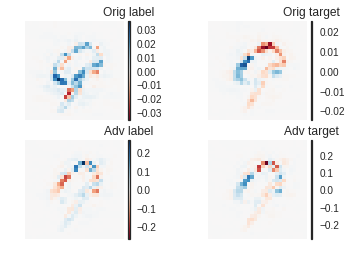

In [75]:
plt.subplot(2,2,1)
viz.visualize_preds(scores_ig, label)
plt.title('Orig label')
plt.subplot(2,2,2)
viz.visualize_preds(scores_ig, target)
plt.title('Orig target')
plt.subplot(2,2,3)
viz.visualize_preds(scores_ig_adv, label)
plt.title('Adv label')
plt.subplot(2,2,4)
viz.visualize_preds(scores_ig_adv, target)
plt.title('Adv target')
print(target)
plt.show()

## analyze results_list

0 fname results_list_deepfoolattack_250-350sweep_dim=1use_abs=False.pkl


/accounts/projects/vision/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1 fname results_list_saliency_250-350sweep_dim=1use_abs=True.pkl
2 fname results_list_gradientattack_250-350sweep_dim=8use_abs=False.pkl
3 fname results_list_fgsm_250-350sweep_dim=8use_abs=True.pkl
4 fname results_list_boundaryattack_250-350sweep_dim=2use_abs=True.pkl
5 fname results_list_boundaryattack_250-350sweep_dim=1use_abs=False.pkl
6 fname results_list_saliency_250-350sweep_dim=16use_abs=False.pkl
7 fname results_list_deepfoolattack_250-350sweep_dim=2use_abs=True.pkl
8 fname results_list_boundaryattack_250-350sweep_dim=2use_abs=False.pkl
9 fname results_list_fgsm_250-350sweep_dim=4use_abs=False.pkl
10 fname results_list_gradientattack_250-350sweep_dim=4use_abs=True.pkl


KeyboardInterrupt: 

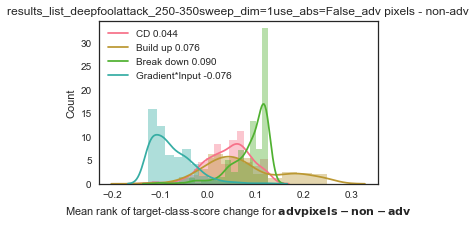

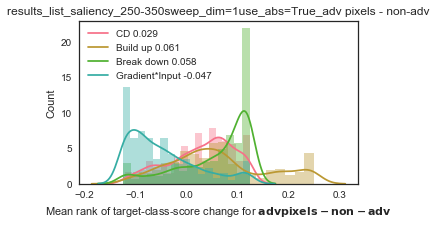

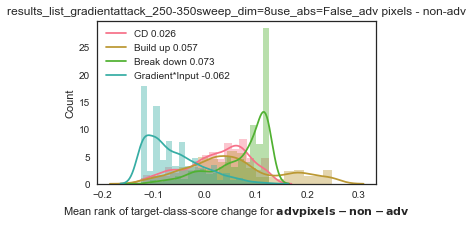

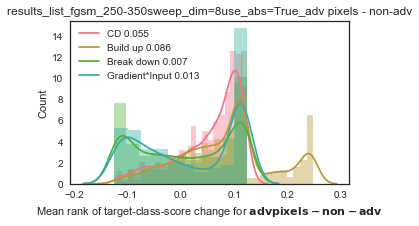

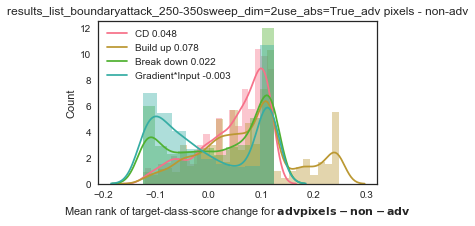

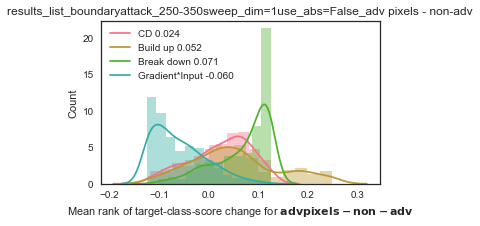

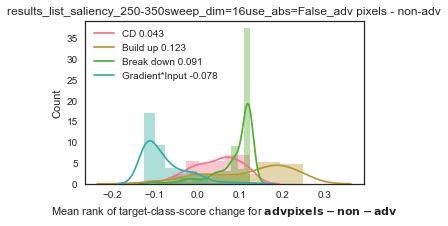

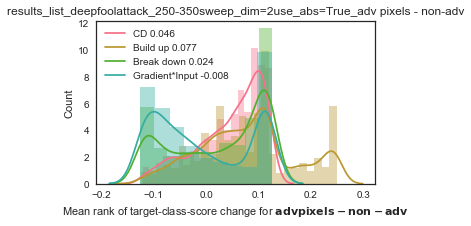

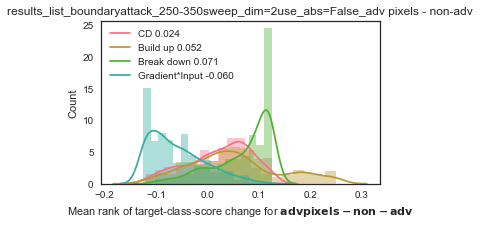

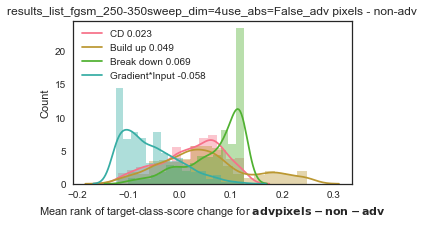

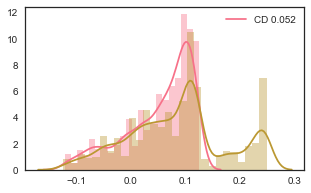

In [17]:
def remove_nans(arrs):
    idxs = np.isnan(arrs[0])
    for arr in arrs:
        idxs += np.isnan(arr)
    return [arr[~idxs] for arr in arrs]

# load
results_dir = 'adv_results/results_good'
plot_types = ['adv pixels - non-adv', 'adv pixels', 'non-adv pixels']
num = 0
for plot_type in plot_types:
    out_dir = oj(results_dir, plot_type)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    for fname in os.listdir(results_dir):
        if '.pkl' in fname:
            print(num, 'fname', fname)
            num += 1
            results_list = pickle.load(open(oj(results_dir, fname), 'rb'))
#             print(len(results_list), results_list[0].keys())


            fname = fname[:-4] + '_' + plot_type
            cd_sel = np.array([r['cd_mean_score_diff_selected'] for r in results_list])
            cd_un = np.array([r['cd_mean_score_diff_unchanged'] for r in results_list])
            b_sel = np.array([r['build_mean_score_diff_selected'] for r in results_list])
            b_un = np.array([r['build_mean_score_diff_unchanged'] for r in results_list])
            br_sel = np.array([r['break_mean_score_diff_selected'] for r in results_list])
            br_un = np.array([r['break_mean_score_diff_unchanged'] for r in results_list])
            ig_sel = np.array([r['ig_mean_score_diff_selected'] for r in results_list])
            ig_un = np.array([r['ig_mean_score_diff_unchanged'] for r in results_list])

            # remove nans
            arrs = remove_nans([cd_sel, cd_un, b_sel, b_un, br_sel, br_un, ig_sel, ig_un])
            if plot_type == 'adv pixels - non-adv':
                arrs = [arrs[2*i]-arrs[2*i+1] for i in range(int(len(arrs)/2))]
            elif plot_type == 'adv pixels':
                arrs = [arrs[2*i] for i in range(int(len(arrs)/2))]
            elif plot_type == 'non-adv pixels':
                arrs = [arrs[2*i+1] for i in range(int(len(arrs)/2))]
                
            # print(b_sel, b_un, br_sel, cd_un)
            def plot_hists(arrs):
                plt.figure(figsize=(5, 3))
                for i, lab in enumerate(['CD', 'Build up', 'Break down', 'Gradient*Input']):
                    sns.distplot(arrs[i], kde_kws={"label": lab + ' ' + str.format("%.3f" % np.mean(arrs[i]))})
                plt.xlabel('Mean rank of target-class-score change for ' + r"$\bf{adv pixels - non-adv}$")
                plt.ylabel('Count')
#                 plt.xlim((-1, 1))
            plot_hists(arrs)
            plt.title(fname)
            plt.savefig(oj(out_dir, fname + '.png'), dpi=150)
#             plt.show()

# plot adv-non_adv results

0 fname results_list_boundaryattack_250-350sweep_dim=16use_abs=False.pkl
1 fname results_list_boundaryattack_250-350sweep_dim=1use_abs=False.pkl
2 fname results_list_deepfoolattack_250-350sweep_dim=16use_abs=False.pkl
3 fname results_list_deepfoolattack_250-350sweep_dim=1use_abs=False.pkl
4 fname results_list_fgsm_250-350sweep_dim=16use_abs=False.pkl
5 fname results_list_fgsm_250-350sweep_dim=1use_abs=False.pkl
6 fname results_list_gradientattack_250-350sweep_dim=16use_abs=False.pkl
7 fname results_list_gradientattack_250-350sweep_dim=1use_abs=False.pkl
8 fname results_list_saliency_250-350sweep_dim=16use_abs=False.pkl
9 fname results_list_saliency_250-350sweep_dim=1use_abs=False.pkl


/accounts/projects/vision/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


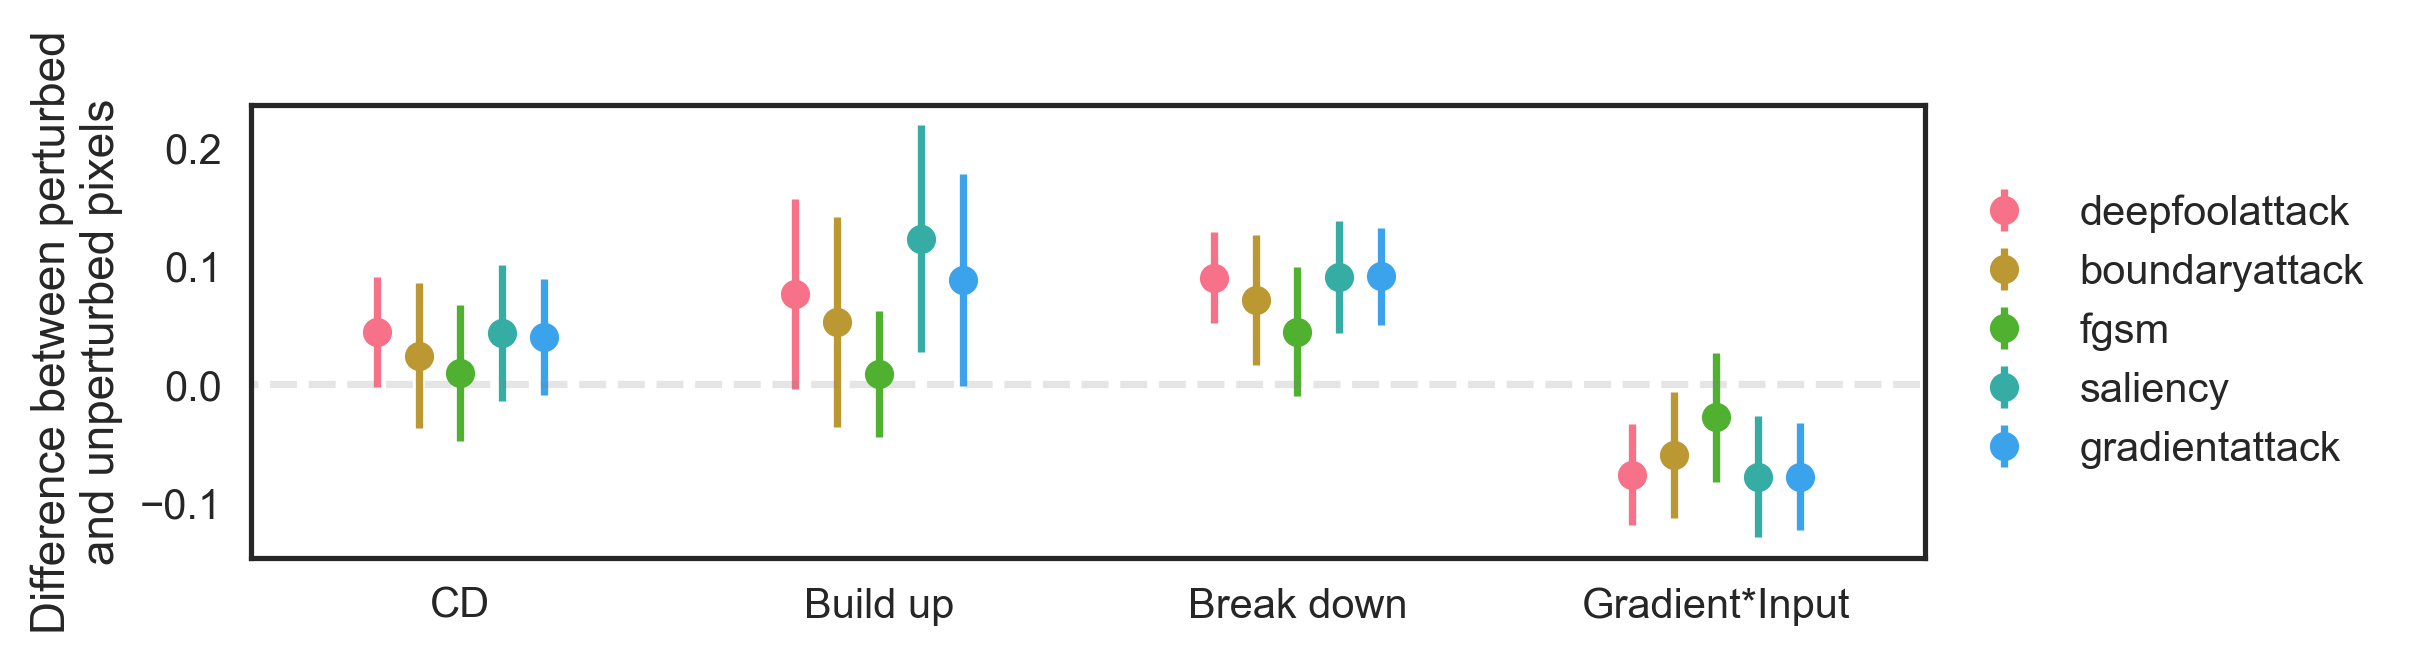

In [18]:
# load
results_dir = 'adv_results/results_good'
num = 0
distrs = {}
for fname in sorted(os.listdir(results_dir)):
    if '.pkl' in fname and 'sweep_dim=1' in fname and 'use_abs=False' in fname:
        print(num, 'fname', fname)
        num += 1
        results_list = pickle.load(open(oj(results_dir, fname), 'rb'))
        attack_type = fname[fname.index('list_')+5:fname.index('_250')]

        fname = fname[:-4] + '_' + plot_type
        cd_sel = np.array([r['cd_mean_score_diff_selected'] for r in results_list])
        cd_un = np.array([r['cd_mean_score_diff_unchanged'] for r in results_list])
        b_sel = np.array([r['build_mean_score_diff_selected'] for r in results_list])
        b_un = np.array([r['build_mean_score_diff_unchanged'] for r in results_list])
        br_sel = np.array([r['break_mean_score_diff_selected'] for r in results_list])
        br_un = np.array([r['break_mean_score_diff_unchanged'] for r in results_list])
        ig_sel = np.array([r['ig_mean_score_diff_selected'] for r in results_list])
        ig_un = np.array([r['ig_mean_score_diff_unchanged'] for r in results_list])

        # remove nans
        arrs = remove_nans([cd_sel, cd_un, b_sel, b_un, br_sel, br_un, ig_sel, ig_un])
        means = [np.mean(arrs[2*i]-arrs[2*i+1]) for i in range(int(len(arrs)/2))]
        stds = [np.std(arrs[2*i]-arrs[2*i+1]) for i in range(int(len(arrs)/2))]
        
        distrs[attack_type] = (means, stds)
    
plt.figure(figsize=(9, 2), dpi=300)    
for i, attack_type in enumerate(distrs):
    means = distrs[attack_type][0]
    stds = distrs[attack_type][1]
    plt.errorbar(np.arange(len(means)) + i * 0.1, means, yerr=stds, label=attack_type, fmt='o')
    
ax = plt.subplot(111)
plt.plot([-1, 4], [0, 0], '--', color='gray', alpha=0.2)
plt.xlim(-.3, 3.7)
    

plt.xticks([0.2, 1.2, 2.2, 3.2], ['CD', 'Build up', 'Break down', 'Gradient*Input'])
plt.ylabel('Difference between perturbed\nand unperturbed pixels')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend()
plt.show()

# plot different sweep_dims

0 fname results_list_saliency_250-350sweep_dim=16use_abs=False.pkl
1 fname results_list_saliency_250-350sweep_dim=1use_abs=False.pkl
2 fname results_list_saliency_250-350sweep_dim=2use_abs=False.pkl
3 fname results_list_saliency_250-350sweep_dim=4use_abs=False.pkl
4 fname results_list_saliency_250-350sweep_dim=8use_abs=False.pkl


/accounts/projects/vision/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


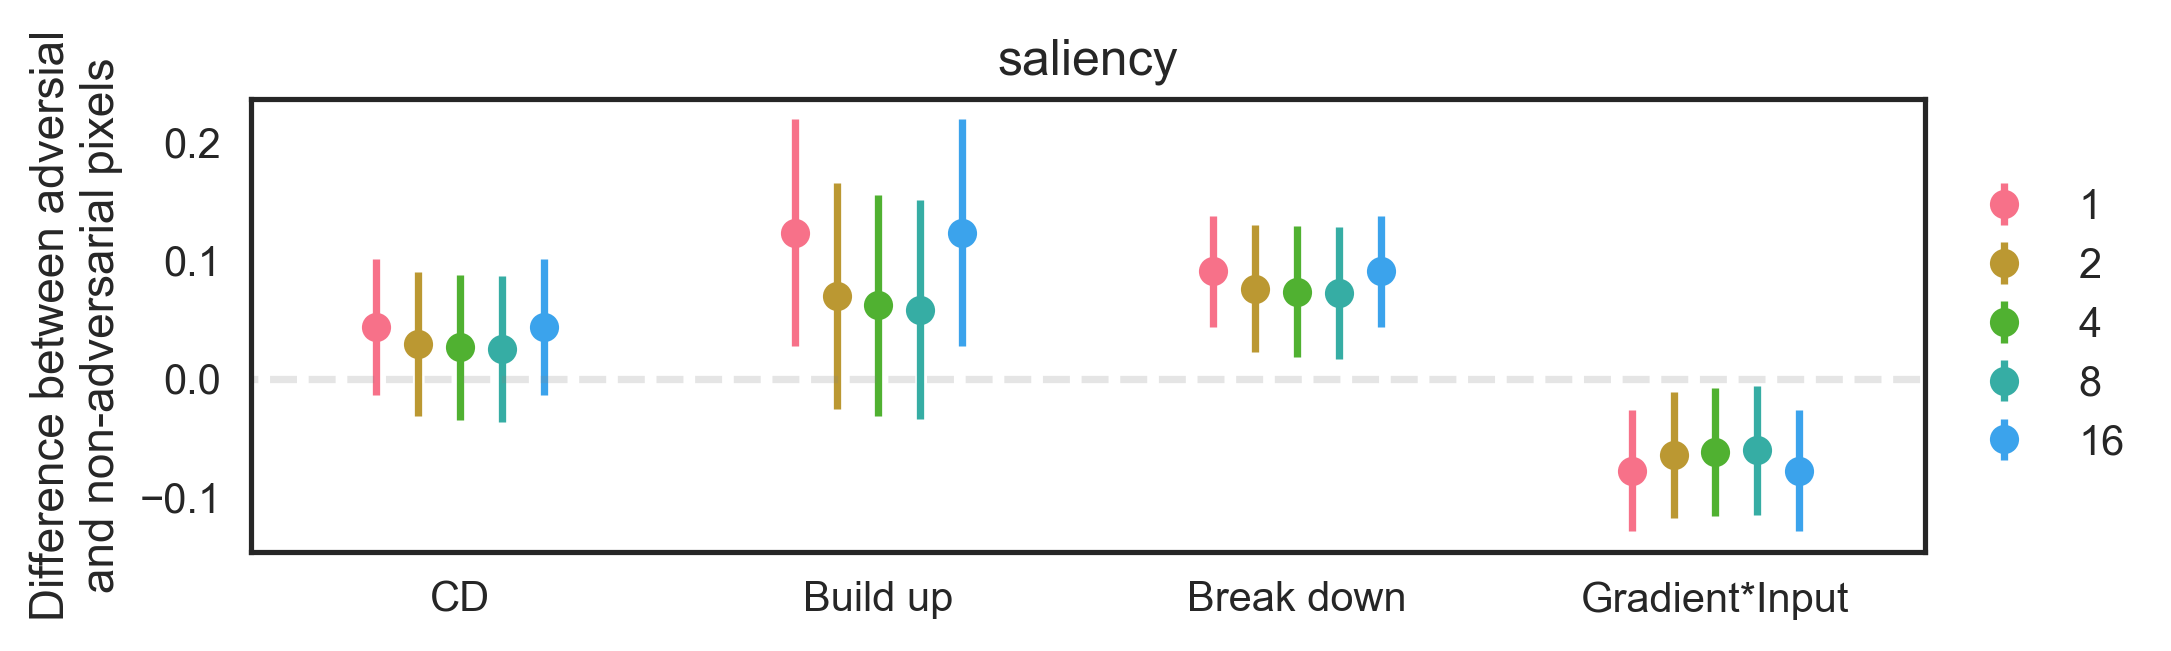

In [19]:
# load
results_dir = 'adv_results/results_good'
num = 0
distrs = {}
attack_type = 'saliency' #['fgsm', 'saliency', 'gradientattack', 'deepfoolattack', 'boundaryattack']
for fname in sorted(os.listdir(results_dir)):
    if '.pkl' in fname and attack_type in fname and 'use_abs=False' in fname:
        print(num, 'fname', fname)
        num += 1
        results_list = pickle.load(open(oj(results_dir, fname), 'rb'))
        sweep_dim = fname[fname.index('dim=')+4:fname.index('use_abs')]

        cd_sel = np.array([r['cd_mean_score_diff_selected'] for r in results_list])
        cd_un = np.array([r['cd_mean_score_diff_unchanged'] for r in results_list])
        b_sel = np.array([r['build_mean_score_diff_selected'] for r in results_list])
        b_un = np.array([r['build_mean_score_diff_unchanged'] for r in results_list])
        br_sel = np.array([r['break_mean_score_diff_selected'] for r in results_list])
        br_un = np.array([r['break_mean_score_diff_unchanged'] for r in results_list])
        ig_sel = np.array([r['ig_mean_score_diff_selected'] for r in results_list])
        ig_un = np.array([r['ig_mean_score_diff_unchanged'] for r in results_list])

        # remove nans
        arrs = remove_nans([cd_sel, cd_un, b_sel, b_un, br_sel, br_un, ig_sel, ig_un])
        means = [np.mean(arrs[2*i]-arrs[2*i+1]) for i in range(int(len(arrs)/2))]
        stds = [np.std(arrs[2*i]-arrs[2*i+1]) for i in range(int(len(arrs)/2))]
        
        distrs[sweep_dim] = (means, stds)
    
plt.figure(figsize=(9, 2), dpi=300)    
for i, sweep_dim in enumerate(sorted([int(k) for k in distrs.keys()])):
    sweep_dim = str(sweep_dim)
    means = distrs[sweep_dim][0]
    stds = distrs[sweep_dim][1]
    plt.errorbar(np.arange(len(means)) + i * 0.1, means, yerr=stds, label=sweep_dim, fmt='o')
    
ax = plt.subplot(111)
plt.title(attack_type)
plt.plot([-1, 4], [0, 0], '--', color='gray', alpha=0.2)
plt.xlim(-.3, 3.7)
    

plt.xticks([0.2, 1.2, 2.2, 3.2], ['CD', 'Build up', 'Break down', 'Gradient*Input'])
plt.ylabel('Difference between adversial\nand non-adversarial pixels')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend()
plt.show()

# visualize ex

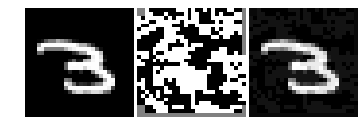

	label: 3 0.6761339 -> 0.36680317
	target: 2 0.18515798 -> 0.37429506


In [22]:
plt.figure(figsize=(6, 2))
plt.subplot(131)
plt.imshow(im_orig, cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.imshow(im_orig_adv - im_orig, cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.imshow(im_orig_adv, cmap='gray')
plt.axis('off')
plt.subplots_adjust(wspace=0)
plt.show()

print('\tlabel:', results['label'], results['pred_orig[label]'], '->', results['pred_adv[label]'])
print('\ttarget:', results['target'], results['pred_orig[target]'], '->', results['pred_adv[target]'])

# visualize score corrs

/accounts/projects/vision/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


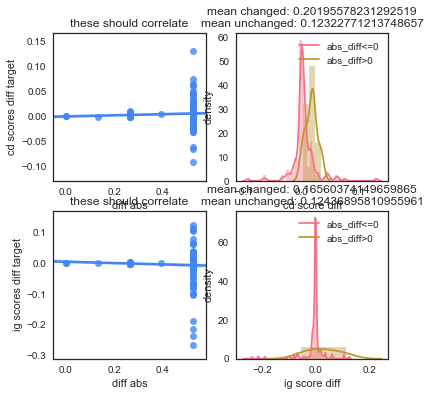

In [29]:
R, C = 2, 2
plt.figure(figsize=(6, 6))
target = results['target']
thresh = 0

plt.subplot(R, C, 1)
sns.regplot(diff_abs_flat, scores_diff, color='#4286f4')
# plt.plot(diff_abs_flat, scores_flat, 'o')
plt.xlabel('diff abs')
plt.ylabel('cd scores diff target')
plt.title('these should correlate')

plt.subplot(R, C, 2)
sns.distplot(scores_diff[unchanged], kde_kws={"label": "abs_diff<=" + str(thresh)})
sns.distplot(scores_diff[selected_pixels], kde_kws={"label": "abs_diff>" + str(thresh)})
plt.xlabel('cd score diff')
plt.ylabel('density')


plt.title('mean changed: ' + str(results['cd_mean_score_diff_selected']) + 
          '\nmean unchanged: ' + str(results['cd_mean_score_diff_unchanged']))
# plt.xlim((0, .04))

plt.subplot(R, C, C+1)
sns.regplot(diff_abs_flat, scores_diff_ig, color='#4286f4')
# plt.plot(diff_abs_flat, scores_flat, 'o')
plt.xlabel('diff abs')
plt.ylabel('ig scores diff target')
plt.title('these should correlate')

plt.subplot(R, C, C+2)
# sns.regplot(diff_abs_flat, np.abs(scores_cd_adv_flat_target), color='#4286f4')
# plt.plot(diff_abs_flat, scores_flat, 'o')

sns.distplot(scores_diff_ig[unchanged], kde_kws={"label": "abs_diff<=" + str(thresh)})
sns.distplot(scores_diff_ig[selected_pixels], kde_kws={"label": "abs_diff>" + str(thresh)})
plt.xlabel('ig score diff')
plt.ylabel('density')

plt.title('mean changed: ' + str(results['ig_mean_score_diff_selected']) + 
          '\nmean unchanged: ' + str(results['ig_mean_score_diff_unchanged']))
# plt.xlim((0, .04))

plt.show()